<a href="https://colab.research.google.com/github/NadaMohammedB/Skin-Cancer-Classifier/blob/main/LogisticRegressionproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Digital Image Processing Project

---

    Course Title:                      Digital Image Processing
    *Course Code:*                     CS456
    *Course Instructor:*               Dr. Fahman Saeed

    *Group Members*

         Students IDs                  Students Names
    -------------------------------------------------------------
          442015103                    Dalal Abdullatif Albaijan
          442014013                    Lulu Mohammed Alkhalaf
          442012933                    NADA Mohammed Alotaibi

          Semester:                    1446 -- 1st Semester
          Due Date:                    11th week.

---

In this project, we utilized the public dataset "Skin Cancer: Malignant vs. Benign" to explore various image enhancement techniques, including Histogram Equalization and Sharpening, to improve image quality. We applied feature extraction methods such as Scale-Invariant Feature Transform (SIFT), Local Binary Patterns (LBP), and Histogram of Oriented Gradients (HOG) to extract relevant features from the images. Additionally, we implemented an ensemble learning approach that combined the predictions of multiple models, including VGG16, a convolutional neural network known for its depth and effectiveness in image classification. Finally, we employed Support Vector Machines (SVM) and Random Forest classifiers to accurately classify the images as malignant or benign, demonstrating the effectiveness of combining these techniques for improved skin cancer detection.

Below are the implementation details of all the algorithms.

---


# **Dataset Selection and Preprocessing**


# Dataset

Skin Cancer: Malignant vs Benign dataset from Kaggle is the one used. Dermoscopy image dataset of skin lesions represented as malignant or benign; hence, this dataset shall be very useful for the binary classification problems in medical imaging. It includes:



Images: 3,297 dermoscopy images are present in this dataset about malignant and benign lesions of the skin.

Size: Approximately 1800 benign and approximately 1400 malignant images.

Image Format: Images are provided in JPEG format at different dimensions and resolutions.

Important libraries

In [ ]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.svm import SVC
from skimage import exposure
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from skimage.feature import local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score

Load data from kaggle into colab by using opendatasets

In [ ]:
%pip install -q opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dalalab
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign


100%|██████████| 325M/325M [00:17<00:00, 19.9MB/s]


Restructuring files

In [ ]:
source_train_benign = '/content/skin-cancer-malignant-vs-benign/train/benign'
source_test_benign = '/content/skin-cancer-malignant-vs-benign/test/benign'
source_train_malignant = '/content/skin-cancer-malignant-vs-benign/train/malignant'
source_test_malignant = '/content/skin-cancer-malignant-vs-benign/test/malignant'

destination_benign = '/content/skin-cancer-malignant-vs-benign/benign'
destination_malignant = '/content/skin-cancer-malignant-vs-benign/malignant'

os.makedirs(destination_benign, exist_ok=True)
os.makedirs(destination_malignant, exist_ok=True)

def move_files(source_folder, destination_folder):
    for filename in os.listdir(source_folder):
        source_file = os.path.join(source_folder, filename)
        destination_file = os.path.join(destination_folder, filename)

        if not os.path.exists(destination_file):
            shutil.move(source_file, destination_file)
        else:
            print(f"{filename} already exists in {destination_folder}, skipping...")

move_files(source_train_benign, destination_benign)
move_files(source_test_benign, destination_benign)

move_files(source_train_malignant, destination_malignant)
move_files(source_test_malignant, destination_malignant)

print("All files moved successfully!")


All files moved successfully!


We delete duplicate and unnecessary folder

In [ ]:
folders_to_delete = [
    '/content/skin-cancer-malignant-vs-benign/data',
    '/content/skin-cancer-malignant-vs-benign/test',
    '/content/skin-cancer-malignant-vs-benign/train'
]

for folder_path in folders_to_delete:
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"Deleted folder: {folder_path}")
    else:
        print(f"Folder not found: {folder_path}")


Deleted folder: /content/skin-cancer-malignant-vs-benign/data
Deleted folder: /content/skin-cancer-malignant-vs-benign/test
Deleted folder: /content/skin-cancer-malignant-vs-benign/train


Rename images because some images have the same ids number and we do it for each folder ( train and test )


In [ ]:
source_folder = '/content/skin-cancer-malignant-vs-benign/benign'

for filename in os.listdir(source_folder):
    if filename.endswith('.jpg'):
        new_filename = 'B' + filename
        source_path = os.path.join(source_folder, filename)
        destination_path = os.path.join(source_folder, new_filename)


        os.rename(source_path, destination_path)

In [ ]:
source_folder = '/content/skin-cancer-malignant-vs-benign/malignant'

for filename in os.listdir(source_folder):
    if filename.endswith('.jpg'):
        new_filename = 'M' + filename
        source_path = os.path.join(source_folder, filename)
        destination_path = os.path.join(source_folder, new_filename)

        os.rename(source_path, destination_path)

Displaying 5 samples of datasets

Saved all images to the '/content/saved_images' folder.


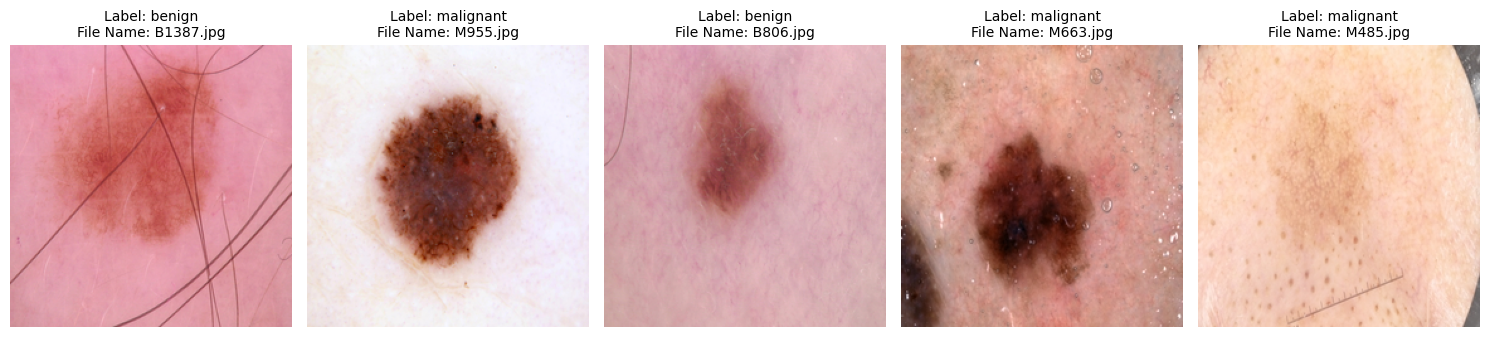

Displayed 5 sample images from the '/content/saved_images' folder.


In [ ]:
benign = '/content/skin-cancer-malignant-vs-benign/benign'
malignant = '/content/skin-cancer-malignant-vs-benign/malignant'

file_paths = (
    [os.path.join(benign, f) for f in os.listdir(benign)] +
    [os.path.join(malignant, f) for f in os.listdir(malignant)]
)

labels = (
    ['benign'] * len(os.listdir(benign)) +
    ['malignant'] * len(os.listdir(malignant))
)
file_names = [os.path.basename(path) for path in file_paths]

data = pd.DataFrame({'file_name': file_names, 'label': labels, 'file_path': file_paths})

save_folder = '/content/saved_images'
os.makedirs(save_folder, exist_ok=True)

for path, name in zip(file_paths, file_names):
    img = cv2.imread(path)
    save_path = os.path.join(save_folder, name)
    cv2.imwrite(save_path, img)
print(f"Saved all images to the '{save_folder}' folder.")

sample_data = data.sample(5)

plt.figure(figsize=(15, 15))

for i, (index, row) in enumerate(sample_data.iterrows(), 1):
    img = cv2.imread(row['file_path'])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 5, i)
    plt.imshow(img_rgb)
    plt.title(f"Label: {row['label']}\nFile Name: {row['file_name']}", fontsize=10)  # Display label and file name
    plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Displayed 5 sample images from the '{save_folder}' folder.")

# Image Enhancement

This process involves applying noise reduction and histogram equalization (HEQ) to images, then saving the results into specific folders.

1- 3x3 sharpening filter kernel is created to enhance the edges and details of the image.

2- The code iterates over each image file in the dataset directory, with the filenames extracted using os.path.basename().

3- Each image is read and converted to grayscale using cv2.imread() with the cv2.IMREAD_GRAYSCALE flag.

4- The sharpening filter is applied to the grayscale image using cv2.filter2D().

5- Histogram equalization is performed on the grayscale image using cv2.equalizeHist() to improve contrast.

6- The sharpened image is saved in the "/content/Sharpened_Images/" directory using cv2.imwrite().

7- The histogram equalized image is saved in the "/content/Histogram_Images/" directory, also using cv2.imwrite().

8- Each processed image is saved with its original filename in the appropriate folder for further use.

In [ ]:
dataset_dir = '/content/saved_images'

sharpened_dir = '/content/Sharpened_Images'
histogram_dir = '/content/Histogram_Images'

os.makedirs(sharpened_dir, exist_ok=True)
os.makedirs(histogram_dir, exist_ok=True)

image_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith('.jpg')]

kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

for image_file in image_files:

    filename = os.path.basename(image_file)
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

    sharpened_image = cv2.filter2D(image, -1, kernel)

    equalized_image = cv2.equalizeHist(image)

    sharpened_save_path = os.path.join(sharpened_dir, filename)
    cv2.imwrite(sharpened_save_path, sharpened_image)

    histogram_save_path = os.path.join(histogram_dir, filename)
    cv2.imwrite(histogram_save_path, equalized_image)

print("Images processed and saved to their respective folders.")


Images processed and saved to their respective folders.


# Visualization

Display 5 images of each original image, sharpened and histogram equalization

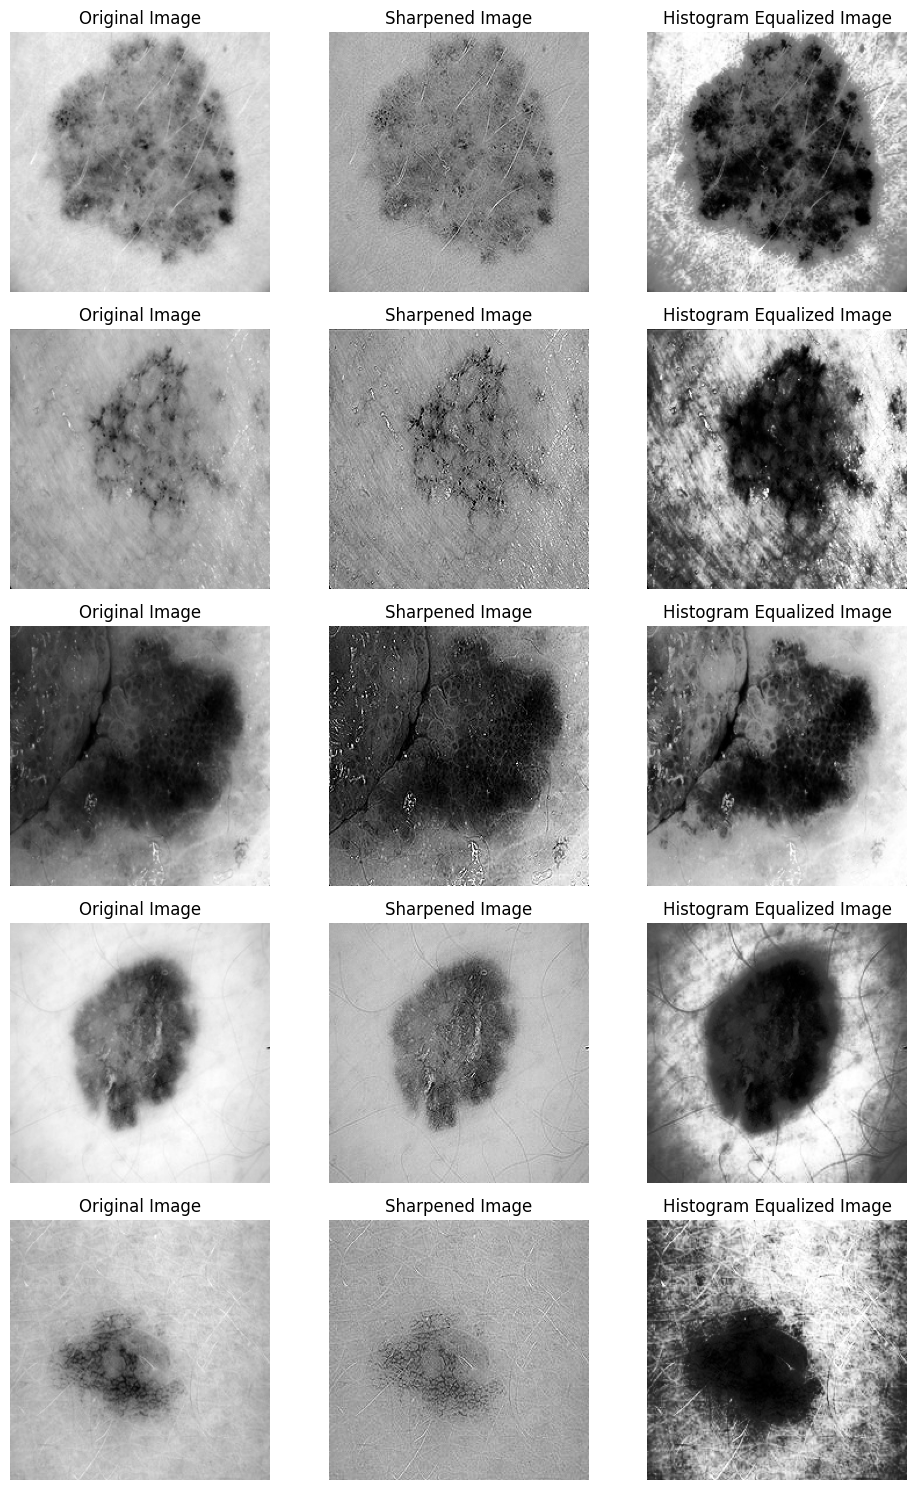

In [ ]:
def display_images():
    image_names = [f for f in os.listdir('/content/Sharpened_Images') if f.endswith(('.jpg', '.png'))][:5]

    fig, axs = plt.subplots(5, 3, figsize=(10, 15))

    for i, image_name in enumerate(image_names):

        image_path1 = os.path.join('/content/saved_images', image_name)
        image_path2 = os.path.join('/content/Sharpened_Images', image_name)
        image_path3 = os.path.join('/content/Histogram_Images', image_name)

        image1 = Image.open(image_path1).convert('L')
        image2 = Image.open(image_path2)
        image3 = Image.open(image_path3)

        axs[i, 0].imshow(image1, cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 0].set_title('Original Image')


        axs[i, 1].imshow(image2, cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].set_title('Sharpened Image')

        axs[i, 2].imshow(image3, cmap='gray')
        axs[i, 2].axis('off')
        axs[i, 2].set_title('Histogram Equalized Image')

    plt.tight_layout()
    plt.show()

display_images()


A sharpening image you can observe that  increasing the contrast along the edges of objects in the image, thereby making them appear sharper compared to original image while histogram equalization image improves the contrast of the image

# Feature Extraction

# **1- Scale Invariant Feature Transform (SIFT)**

SIFT (Scale-Invariant Feature Transform) is an algorithm used for feature detection and matching in computer vision. It is robust to scale and rotation changes in images and can generate distinctive features for object recognition. SIFT involves steps such as scale-space peak selection, keypoint localization, orientation assignment, and keypoint descriptor calculation.


# Apply SIFT and show images


- The code creates a figure with 5 rows and 3 columns of subplots using `plt.subplots()`, adjusting the figure size to (10, 15) for better visualization.
- It adjusts the vertical spacing between subplots using `fig.subplots_adjust()` to ensure proper layout.
- The loop processes the first 5 images from the `image_files` list, performing the following operations:

  1- Extracts the filename from the image path using `os.path.basename()`.

  2- Reads each image using `cv2.imread()` and converts it to grayscale using `cv2.cvtColor()` to prepare for SIFT feature extraction.

  3- Creates a SIFT extractor with `cv2.SIFT_create()` to detect keypoints and compute descriptors using `sift.detectAndCompute()`.

  4- Draws keypoints on the grayscale image using `cv2.drawKeypoints()`, creating an image with overlaid keypoints.

  5- These steps are repeated for the sharpened image and the HEQ (Histogram Equalized) image, using their respective file paths.
  
- Finally, it plots the original image with keypoints, the sharpened image with keypoints, and the HEQ image with keypoints in the corresponding subplots of the current row.
- Each subplot title displays the number of keypoints detected and the shape of the descriptors for the respective image.

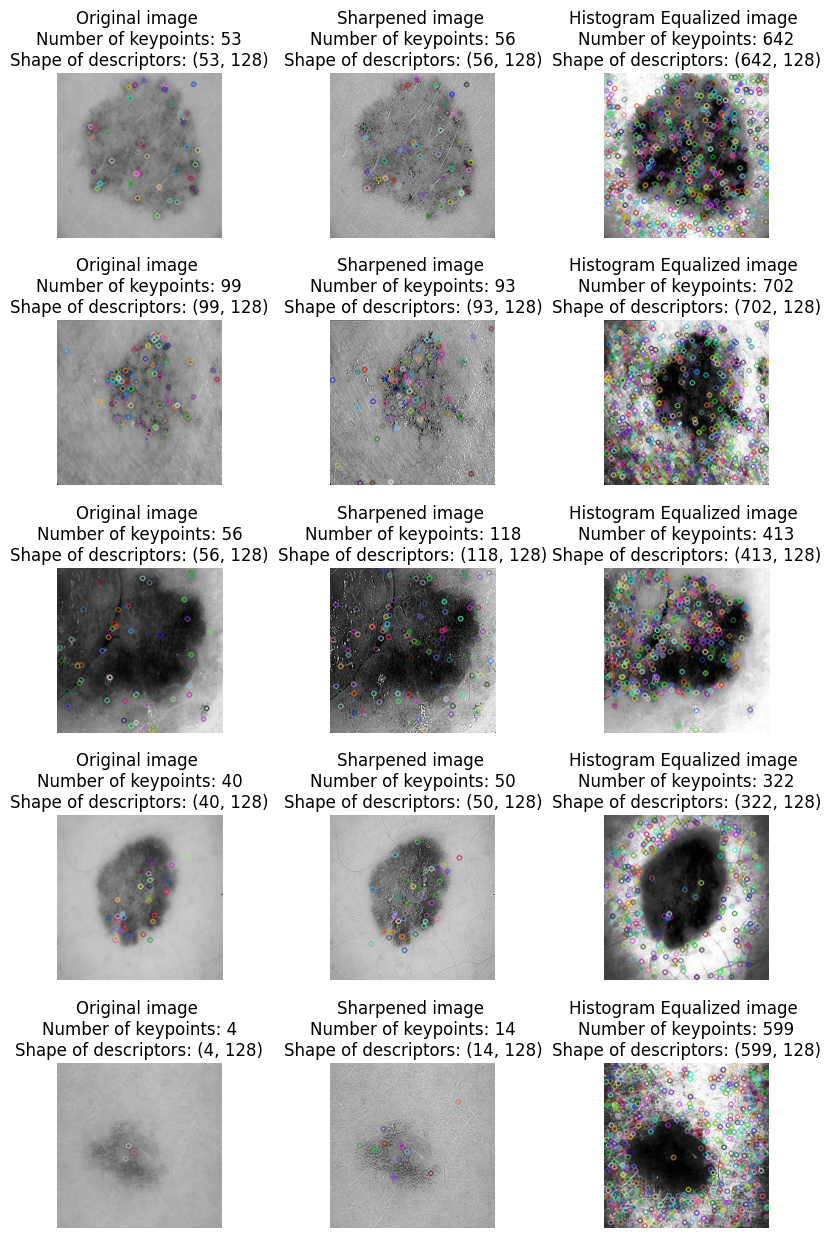

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

image_folder = '/content/saved_images'

image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

fig, axs = plt.subplots(5, 3, figsize=(10, 15))
fig.subplots_adjust(hspace=0.5)

for i, image_file in enumerate(image_files[:5]):

    filename = os.path.basename(image_file)

    img1 = cv2.imread(image_file)
    if img1 is None:
        print(f"Error: Could not load image {image_file}. Check the file path.")
        continue

    gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    sift_image = cv2.drawKeypoints(gray, keypoints, img1)

    sharpened_image_path = os.path.join('/content/Sharpened_Images', filename)
    img2 = cv2.imread(sharpened_image_path)
    if img2 is None:
        print(f"Error: Could not load sharpened image {sharpened_image_path}. Check the file path.")
        continue

    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    sift_b = cv2.SIFT_create()
    keypoints_b, descriptors_b = sift_b.detectAndCompute(gray2, None)
    sift_image_b = cv2.drawKeypoints(gray2, keypoints_b, img2)

    heq_image_path = os.path.join('/content/Histogram_Images', filename)
    img3 = cv2.imread(heq_image_path)
    if img3 is None:
        print(f"Error: Could not load HEQ image {heq_image_path}. Check the file path.")
        continue

    gray3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
    sift_h = cv2.SIFT_create()
    keypoints_h, descriptors_h = sift_h.detectAndCompute(gray3, None)
    sift_image_h = cv2.drawKeypoints(gray3, keypoints_h, img3)

    axs[i, 0].imshow(sift_image, cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f'Original image \nNumber of keypoints: {len(keypoints)}\nShape of descriptors: {descriptors.shape}')

    axs[i, 1].imshow(sift_image_b, cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title(f'Sharpened image \nNumber of keypoints: {len(keypoints_b)}\nShape of descriptors: {descriptors_b.shape}')

    axs[i, 2].imshow(sift_image_h, cmap='gray')
    axs[i, 2].axis('off')
    axs[i, 2].set_title(f'Histogram Equalized image \nNumber of keypoints: {len(keypoints_h)}\nShape of descriptors: {descriptors_h.shape}')

plt.show()


**Analysis SIFT feature extractor before and after image enhancement**

Based on the above results, the sharpening and histogram equalization preprocessing techniques have an impact on the number of key points detected. The sharpened image resulted in higher key scores compared to the original image, while the HEQ image had the highest number of key scores.

# Logistic Regression classification and ensemble with SIFT (Original Image)

1. Extract the values from the "image_path" column of the DataFrame and store them in the original_img_paths variable.
2. Extract the values from the "label" column of the DataFrame and store them in the labelss variable.


In [ ]:
original_img_paths = data["file_path"]
labelss = data["label"]

3. Defines a function called `SIFT_feature` that performs image classification using SIFT features and a bag-of-features approach.

    the main steps of the method:
   - Initialize a SIFT feature extractor.
   - Define a function to extract SIFT features from an image.
   - Define a function to compute the bag-of-features representation for a set of features.
   - Iterate over a list of image paths and extract SIFT features for each image, storing them in a list.
   - Vertically stack the extracted features into a single numpy array. Perform k-means clustering on the array of features to obtain cluster centers.
   - Iterate over the image paths and corresponding labels.
   - Extract SIFT features for each image, compute the bag-of-features representation using the cluster centers, and store the representation and label in separate lists.
   - Vertically stack the bag-of-features representations into a single numpy array. Return the bag-of-features array and the list of labels.


In [ ]:
def SIFT_feature(img_paths):

    sift = cv2.SIFT_create()

    def extract_features(image_path):
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error loading image: {image_path}")
            return None
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = sift.detectAndCompute(gray, None)
        return descriptors

    def bag_of_features(features, centres, k=3):
        vec = np.zeros((1, k))
        for i in range(features.shape[0]):
            feat = features[i]
            diff = np.tile(feat, (k, 1)) - centres
            dist = np.sqrt((np.power(diff, 2)).sum(axis=1))
            idx = dist.argsort()[0]
            vec[0][idx] += 1
        return vec


    imgs_features = []
    for image_path in img_paths:
        descriptors = extract_features(image_path)
        if descriptors is not None:
            imgs_features.append(descriptors)

    if len(imgs_features) == 0:
        print("No valid images found.")
        return None, None

    imgs_features = np.vstack(imgs_features)

    k = 3
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1)
    flags = cv2.KMEANS_RANDOM_CENTERS
    compactness, labels, centres = cv2.kmeans(imgs_features, k, None, criteria, 10, flags)

    vec = []
    all_labels = []
    for image_path, label in zip(img_paths, labelss):
        descriptorss = extract_features(image_path)
        if descriptorss is not None:
            img_vec = bag_of_features(descriptorss, centres, k)
            all_labels.append(label)
            vec.append(img_vec)

    vec = np.vstack(vec)
    return vec, all_labels

 4. Calls the classification function with the **original_img_paths** as the argument.
 5. Split vec and all_labels into training and testing sets using train_test_split().

In [ ]:
vec , all_labels = SIFT_feature(original_img_paths)
X_train, X_test, y_train, y_test = train_test_split(vec, all_labels, test_size=0.1, random_state=42)

**Logistic Regression Model**

6. Defines a function called logistic_regression() for training and testing as following:

- It applies feature scaling to the training and testing sets using StandardScaler.
- It initializes a Logistic Regression classifier with a random state of 42 and a maximum of 1000 iterations, then trains it on the scaled training data.
- It predicts the labels for the scaled testing data using the trained classifier.
- It evaluates the performance of the classifier by calculating accuracy, precision, recall, and F1-score using the predicted labels and the actual labels from the testing set.
- It prints the evaluation metrics including accuracy, precision, recall, and F1-score for the Logistic Regression classifier.


In [ ]:
def logistic_regression():

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    clf = LogisticRegression(random_state=42, max_iter=1000)
    clf.fit(X_train_scaled, y_train)

    predictions = clf.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')


    print(f"Logistic Regression Accuracy: {accuracy * 100:.2f}%")
    print(f"Logistic Regression Precision: {precision * 100:.2f}%")
    print(f"Logistic Regression Recall: {recall * 100:.2f}%")
    print(f"Logistic Regression F1-Score: {f1 * 100:.2f}%")


7. Calling logistic_regression() will execute the code inside the logistic_regression function.

In [ ]:
logistic_regression()

Logistic Regression Accuracy: 68.90%
Logistic Regression Precision: 68.19%
Logistic Regression Recall: 68.90%
Logistic Regression F1-Score: 68.09%


8. Defines a function called `ensemble` by creating voting classifier on SVM and Randomforest classifiers

    * It applies feature scaling to the training and testing sets using StandardScaler.
    * It initializes an SVM classifier and a Random Forest classifier.
    * It creates a Voting Classifier that combines the SVM and Random Forest classifiers using a hard voting strategy.
    * It trains the Voting Classifier on the scaled training data.
    * It predicts the labels for the scaled testing data using the trained Voting Classifier.
    * It evaluates the performance of the classifier by calculating accuracy, precision, recall, and F1-score using the predicted labels and the actual labels from the testing set.
    * It prints the evaluation metrics including accuracy, precision, recall, and F1-score.


In [ ]:
def ensemble():
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    svm_clf = SVC(kernel='linear')

    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

    voting_clf = VotingClassifier(estimators=[('svm', svm_clf), ('rf', rf_clf)], voting='hard')

    voting_clf.fit(X_train_scaled, y_train)

    predictions = voting_clf.predict(X_test_scaled)


    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')


    print(f"Voting Accuracy: {accuracy * 100:.2f}%")
    print(f"Voting Precision: {precision * 100:.2f}%")
    print(f"Voting Recall: {recall * 100:.2f}%")
    print(f"Voting F1-Score: {f1 * 100:.2f}%")

9. Calling ensemble() will execute the code inside the ensemble function.


In [ ]:
ensemble()

Voting Accuracy: 70.43%
Voting Precision: 69.90%
Voting Recall: 70.43%
Voting F1-Score: 69.18%


# Logistic Regression classification and ensemble with SIFT (Sharpened Image)

The steps are same as above of original image but now only path changed to be on sharpened images and repeat same steps

In [ ]:
data['sharpened_img_path'] = "/content/Sharpened_Images/" + data['file_name']  # Added missing slash

sharpened_img_paths = data["sharpened_img_path"]
labelss = data["label"]


In [ ]:
vec , all_labels = SIFT_feature(sharpened_img_paths)
X_train, X_test, y_train, y_test = train_test_split(vec, all_labels, test_size=0.1, random_state=42)

In [ ]:
logistic_regression()

Logistic Regression Accuracy: 72.42%
Logistic Regression Precision: 72.21%
Logistic Regression Recall: 72.42%
Logistic Regression F1-Score: 71.88%


In [ ]:
ensemble()

Voting Accuracy: 71.21%
Voting Precision: 71.18%
Voting Recall: 71.21%
Voting F1-Score: 70.22%


# Logistic Regression classification and ensemble with SIFT (HEQ Image)

The steps are same as above of original image but now only path changed to be on histogram equalization images and repeat same steps

In [ ]:
data['HEQ_img_path'] = "/content/Histogram_Images/" + data['file_name']
HEQ_img_paths = data["HEQ_img_path"]
labelss = data["label"]

In [ ]:
vec , all_labels = SIFT_feature(HEQ_img_paths)
X_train, X_test, y_train, y_test = train_test_split(vec, all_labels, test_size=0.1, random_state=42)

In [ ]:
logistic_regression()

Logistic Regression Accuracy: 58.79%
Logistic Regression Precision: 57.93%
Logistic Regression Recall: 58.79%
Logistic Regression F1-Score: 58.10%


In [ ]:
ensemble()

Voting Accuracy: 58.79%
Voting Precision: 57.00%
Voting Recall: 58.79%
Voting F1-Score: 56.26%


# **2- Histogram of Oriented Gradients (HOG)**

Histogram of Oriented Gradients (HOG) is an effective feature descriptor used in skin cancer classification to distinguish between malignant and benign lesions. By calculating image gradients, HOG captures essential details such as edges, texture, and shape, which are critical for identifying cancerous patterns. Malignant lesions often have irregular borders and asymmetrical shapes, while benign lesions are more uniform. HOG represents these variations through a feature vector, which can be used to train machine learning models like SVMs , aiding in accurate and early diagnosis of skin cancer.

# Apply HOG and Show images

The code creates a figure with 5 rows and 3 columns of subplots, setting the figure size to (10, 15) and adjusting the vertical spacing between the subplots for better separation. It iterates over the first 5 image files in a specified folder. For each image:

- Base Name Extraction: The base name of the image file is extracted.
- Original Image: The original image is read, converted to grayscale, and its - - HOG features and HOG visualization are extracted using the hog() function.
- The resulting HOG image is displayed in the first column of the current subplot.
- Sharpened Image: The corresponding sharpened image is read, processed similarly, and its HOG image is displayed in the second column.

- Histogram Equalized (HEQ) Image: The HEQ image is read and processed, with its HOG image displayed in the third column.

For each subplot, the axis labels and ticks are turned off, and a title is set to indicate the type of image being displayed. Finally, plt.show() is called to render the complete figure with all subplots.


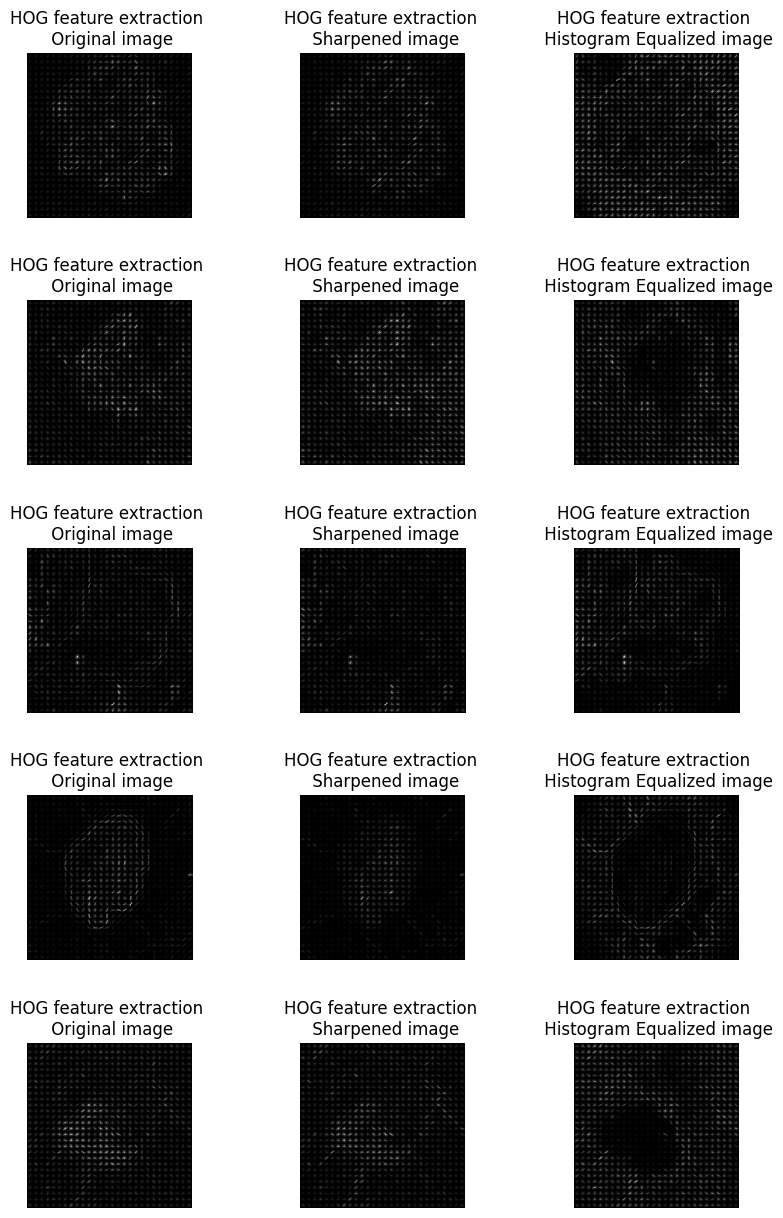

In [ ]:
image_folder = '/content/saved_images'

image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

fig, axs = plt.subplots(5, 3, figsize=(10, 15))
fig.subplots_adjust(hspace=0.5)

for i, image_file in enumerate(image_files[:5]):

    filename = os.path.basename(image_file)

    img1 = cv2.imread(image_file)
    if img1 is None:
        print(f"Error: Could not load image {image_file}. Check the file path.")
        continue

    gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

    features, hog_image = hog(gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    axs[i, 0].imshow(hog_image, cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 0].set_title('HOG feature extraction \n Original image')

    sharpened_image_path = os.path.join('/content/Sharpened_Images', filename)
    img2 = cv2.imread(sharpened_image_path)
    if img2 is None:
        print(f"Error: Could not load sharpened image {sharpened_image_path}. Check the file path.")
        continue

    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    features_b, hog_image_b = hog(gray2, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    axs[i, 1].imshow(hog_image_b, cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title('HOG feature extraction \n Sharpened image')


    heq_image_path = os.path.join('/content/Histogram_Images', filename)
    img3 = cv2.imread(heq_image_path)
    if img3 is None:
        print(f"Error: Could not load HEQ image {heq_image_path}. Check the file path.")
        continue

    gray3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
    features_h, hog_image_h = hog(gray3, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    axs[i, 2].imshow(hog_image_h, cmap='gray')
    axs[i, 2].axis('off')
    axs[i, 2].set_title('HOG feature extraction \n Histogram Equalized image')

plt.show()

# Logistic Regression classification and ensemble with HOG (Original Image)

1. Defines a function called HOG_Features that extracts Histogram of Oriented Gradient (HOG) features from a set of images.
    * Reads each image from the given image_path using OpenCV's cv2.imread function and converts it to grayscale.
    * If an image cannot be read, it prints an error message and returns an array of zeros with a size of (3780,). You may need to adjust this size based on your HOG settings.
    * Extracts the HOG features from the grayscale image using the hog function, specifying parameters such as the number of orientations, pixels per cell, cells per block, block normalization method, and whether to visualize the HOG image.
    * Converts the extracted HOG features into a NumPy array.
    * Obtains the labels from a variable named data  and converts them into a NumPy array.
    * Returns a tuple containing the extracted features and labels.

In [ ]:
def  HOG_Features (images_path):

    def extract_hog_features(image_path):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Image at {image_path} could not be read")
            return np.zeros((3780,))
        hog_features = hog(image, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False, feature_vector=True)
        return hog_features


    features = np.array([extract_hog_features(img) for img in images_path])
    labels = data['label'].values

    return features,labels

2. The code line extracts HOG features from a set of images specified by original_img_paths and assigns the features to features and the corresponding labels to labels.

In [ ]:
features,labels = HOG_Features ( original_img_paths )

3. The code line splits the dataset into training and testing sets, assigning the input features and corresponding output labels to X_train, X_test, y_train, and y_test, respectively.



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2,random_state=42)

4. Calling logistic_regression() will execute the logistic_regression function, which performs feature scaling, trains an Logistic Regression classifier, predicts labels on the testing set, evaluates the classifier's performance, and prints the evaluation metrics.


In [ ]:
logistic_regression()

Logistic Regression Accuracy: 75.15%
Logistic Regression Precision: 75.45%
Logistic Regression Recall: 75.15%
Logistic Regression F1-Score: 75.23%


5- Calling ensemble() executes the ensemble function, which initializes an SVM classifier and a Random Forest classifier, combines them into a Voting Classifier, trains it, predicts labels on the testing set, evaluates the classifier's performance using metrics such as accuracy, precision, recall, and F1-score, and prints the evaluation metrics.

In [ ]:
ensemble()

Voting Accuracy: 71.36%
Voting Precision: 73.08%
Voting Recall: 71.36%
Voting F1-Score: 69.60%


# Logistic Regression classification and ensemble with HOG (Sharpened Image)

The steps are same as above of original image but now only path changed to be on sharpened images and repeat same steps

In [ ]:
features,labels = HOG_Features (sharpened_img_paths)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2,random_state=42)

In [ ]:
logistic_regression()

Logistic Regression Accuracy: 68.64%
Logistic Regression Precision: 69.46%
Logistic Regression Recall: 68.64%
Logistic Regression F1-Score: 68.78%


In [ ]:
ensemble()

Voting Accuracy: 66.52%
Voting Precision: 68.88%
Voting Recall: 66.52%
Voting F1-Score: 63.13%


# Logistic Regression classification and ensemble with HOG (HEQ Image)

The steps are same as above of original image but now only path changed to be on histogram equalization images and repeat same steps

In [ ]:
features,labels = HOG_Features (HEQ_img_paths)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2,random_state=42)

In [ ]:
logistic_regression()

Logistic Regression Accuracy: 68.64%
Logistic Regression Precision: 69.07%
Logistic Regression Recall: 68.64%
Logistic Regression F1-Score: 68.75%


In [ ]:
ensemble()

Voting Accuracy: 70.00%
Voting Precision: 71.54%
Voting Recall: 70.00%
Voting F1-Score: 68.07%


# **3- Local Binary Pattern (LBP)**

Local Binary Pattern (LBP) is a powerful texture descriptor frequently used in skin cancer classification to differentiate between malignant and benign lesions. LBP encodes the local structure of an image by comparing each pixel's intensity with its surrounding neighbors, generating a binary pattern that reflects texture information. This technique is particularly effective in capturing the subtle variations in skin texture that can indicate malignancy, such as irregularities in lesion borders or variations in pigmentation. By converting these binary patterns into a histogram, LBP creates a compact representation that can be fed into machine learning algorithms, enhancing the classification performance. Its robustness to changes in illumination and ability to provide discriminative texture features make LBP a valuable tool in the early detection and diagnosis of skin cancer.

# Apply LBP and show images

The generate_lbp_features function takes a grayscale image as input, generates LBP features, and returns the enhanced LBP image visualization.

1- Figure Creation: It creates a figure with 5 rows and 3 columns of subplots, setting the size of the figure to (10, 15) and adjusting the vertical spacing between the subplots for better separation.

2- Image Processing Loop: It enters a loop that iterates over the first 5 image files.

Within each iteration:

- Base Name Extraction: The base name of the image file is extracted.
Original Image: The original image is read, converted to grayscale, and LBP features are generated using the generate_lbp_features function.
- The LBP visualization of the original image is displayed in the first column of the current subplot.
- Sharpened Image: The corresponding sharpened image is read and processed similarly, with its LBP features displayed in the second column.
- Histogram Equalized Image: The histogram equalized image is read and processed, and its LBP features are displayed in the third column.

3- Subplot Formatting: The axis labels and ticks are turned off for each subplot, and a title is set to indicate the type of image being displayed.

4- Display: Finally, plt.show() is called to render the complete figure with all subplots.

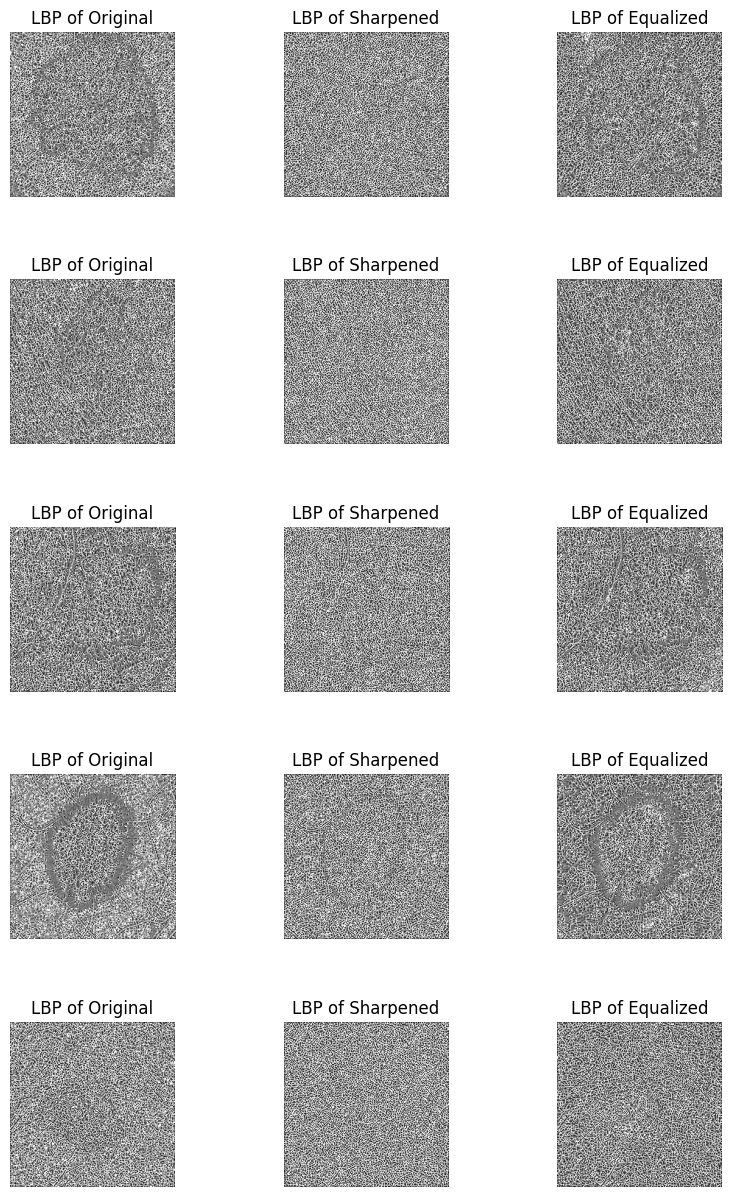

In [ ]:

def generate_lbp_features(grayscale_image):

    lbp_image = local_binary_pattern(grayscale_image, P=8, R=1, method='uniform')

    enhanced_lbp_image = exposure.rescale_intensity(lbp_image, in_range=(0, 10))
    return enhanced_lbp_image

fig, axes = plt.subplots(5, 3, figsize=(10, 15))
fig.subplots_adjust(hspace=0.5)

for i, image_file in enumerate(image_files[:5]):

    filename = os.path.basename(image_file)

    img1 = cv2.imread(image_file)
    if img1 is None:
        print(f"Error: Could not load image {image_file}. Check the file path.")
        continue

    gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    lbp_visual = generate_lbp_features(gray)
    axes[i, 0].imshow(lbp_visual, cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title('LBP of Original')

    sharpened_image_path = os.path.join('/content/Sharpened_Images', filename)
    img2 = cv2.imread(sharpened_image_path)
    if img2 is None:
        print(f"Error: Could not load sharpened image {sharpened_image_path}. Check the file path.")
        continue

    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    lbp_features_sharpened = generate_lbp_features(gray2)
    axes[i, 1].imshow(lbp_features_sharpened, cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('LBP of Sharpened')

    histogram_image_path = os.path.join('/content/Histogram_Images', filename)
    img3 = cv2.imread(histogram_image_path)
    if img3 is None:
        print(f"Error: Could not load histogram equalized image {histogram_image_path}. Check the file path.")
        continue

    gray3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
    lbp_features_equalized = generate_lbp_features(gray3)
    axes[i, 2].imshow(lbp_features_equalized, cmap='gray')
    axes[i, 2].axis('off')
    axes[i, 2].set_title('LBP of Equalized')

plt.show()


# Logistic Regression classification and ensemble with LBP (Original Image)

1. Defines a function called LBP_Features that performs the following steps:

    * Reads each image from the given images_path using OpenCV's cv2.imread function and converts it to grayscale.
    * If an image cannot be read, it prints an error message and returns an array of zeros with a size of your_lbp_feature_size. You should replace your_lbp_feature_size with the actual feature size you want to use.
    * Extracts the LBP features from the grayscale image using the local_binary_pattern function from scikit-image, specifying parameters like the number of points, radius, and method.
    * Flattens the extracted LBP features into a 1D array.
    * Converts the extracted features into a NumPy array.
    * Obtains the labels from a variable named data and converts them into a NumPy array.
    * Returns a tuple containing the extracted features and labels.

In [ ]:
def LBP_Features(images_path):

    def extract_lbp_features(image_path):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Image at {image_path} could not be read")
            return np.zeros((your_lbp_feature_size,))
        lbp_features = local_binary_pattern(image, P=8, R=1, method='uniform').flatten()
        return lbp_features

    features = np.array([extract_lbp_features(img) for img in images_path])
    labels = data['label'].values
    return features,labels

2. The code line extracts LBP features from a set of images specified by original_img_paths and assigns the features to features and the corresponding labels to labels.

In [ ]:
features,labels = LBP_Features ( original_img_paths )

3. The code line splits the dataset into training and testing sets, assigning the input features and corresponding output labels to X_train, X_test, y_train, and y_test, respectively.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2,random_state=42)

4. Calling logistic_regression() will execute the logistic_regression function, which performs feature scaling, trains an Logistic Regression classifier, predicts labels on the testing set, evaluates the classifier's performance, and prints the evaluation metrics.

In [ ]:
logistic_regression()

Logistic Regression Accuracy: 77.12%
Logistic Regression Precision: 78.88%
Logistic Regression Recall: 77.12%
Logistic Regression F1-Score: 77.20%


5- Calling ensemble() executes the ensemble function, which initializes an SVM classifier and a Random Forest classifier, combines them into a Voting Classifier, trains it, predicts labels on the testing set, evaluates the classifier's performance using metrics such as accuracy, precision, recall, and F1-score, and prints the evaluation metrics.

In [ ]:
ensemble()

Voting Accuracy: 67.73%
Voting Precision: 69.60%
Voting Recall: 67.73%
Voting F1-Score: 65.05%


# Logistic Regression classification and ensemble with LBP (Sharpened Image)

The steps are same as above of original image but now only path changed to be on sharpened images and repeat same steps

In [ ]:
features,labels = LBP_Features (sharpened_img_paths)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2,random_state=42)

In [ ]:
logistic_regression()

Logistic Regression Accuracy: 70.61%
Logistic Regression Precision: 72.32%
Logistic Regression Recall: 70.61%
Logistic Regression F1-Score: 70.71%


In [ ]:
ensemble()

Voting Accuracy: 62.42%
Voting Precision: 65.88%
Voting Recall: 62.42%
Voting F1-Score: 56.10%


# Logistic Regression classification and ensemble with LBP (HEQ Image)

The steps are same as above of original image but now only path changed to be on histogram equalization images and repeat same steps

In [ ]:
features,labels = LBP_Features (HEQ_img_paths)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2,random_state=42)

In [ ]:
logistic_regression()

Logistic Regression Accuracy: 73.79%
Logistic Regression Precision: 74.72%
Logistic Regression Recall: 73.79%
Logistic Regression F1-Score: 73.91%


In [ ]:
ensemble()

Voting Accuracy: 63.94%
Voting Precision: 67.01%
Voting Recall: 63.94%
Voting F1-Score: 58.90%


# Pre-trained model (VGG16)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd

X = data['file_path']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def extract_features_in_batches(image_paths, batch_size=10):
    features = []
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        batch_features = []
        for image_path in batch_paths:
            img = load_img(image_path, target_size=(224, 224))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)
            feature = vgg16.predict(img_array)
            batch_features.append(feature.flatten())

        # Append batch features to main features list
        features.extend(batch_features)

    return np.array(features)

X_train_features = extract_features_in_batches(X_train)
X_test_features = extract_features_in_batches(X_test)

np.save('X_train_features.npy', X_train_features)
np.save('X_test_features.npy', X_test_features)

print('Feature extraction complete. Features saved to disk.')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1

In [ ]:
X_train_features = np.load('X_train_features.npy')
X_test_features = np.load('X_test_features.npy')

logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_features, y_train)

y_pred = logistic_model.predict(X_test_features)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary', pos_label='malignant', zero_division=1)
recall = recall_score(y_test, y_pred, average='binary', pos_label='malignant', zero_division=1)
f1 = f1_score(y_test, y_pred, average='binary', pos_label='malignant', zero_division=1)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

unique, counts = np.unique(y_pred, return_counts=True)
prediction_distribution = dict(zip(unique, counts))
print("Prediction distribution:", prediction_distribution)

Accuracy: 0.88
Precision: 0.83
Recall: 0.91
F1-score: 0.87
Prediction distribution: {'benign': 181, 'malignant': 149}


 Feature extraction and classification on sharped images

In [ ]:
data['sharpedimg_path'] = "/content/Sharpened_Images/" + data['file_name']

In [ ]:
X = data['sharpedimg_path']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def extract_features(image_paths):
    features = []
    for image_path in image_paths:
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        feature = vgg16.predict(img_array)
        features.append(feature.flatten())
    return np.array(features)

X_train_features = extract_features(X_train)
X_test_features = extract_features(X_test)

np.save('X_train_sharped_features.npy', X_train_features)
np.save('X_test_sharped_features.npy', X_test_features)

print('Feature extraction complete. Features saved to disk.')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X_train_features = np.load('X_train_sharped_features.npy')
X_test_features = np.load('X_test_sharped_features.npy')

logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_features, y_train)

y_pred = logistic_model.predict(X_test_features)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary', pos_label='malignant', zero_division=1)
recall = recall_score(y_test, y_pred, average='binary', pos_label='malignant', zero_division=1)
f1 = f1_score(y_test, y_pred, average='binary', pos_label='malignant', zero_division=1)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')


Accuracy: 0.84
Precision: 0.78
Recall: 0.84
F1-score: 0.81


 Feature extraction and classification on histogram equalization images

In [ ]:
data['HQ_path'] = "/content/Histogram_Images/" + data['file_name']

In [ ]:
X = data['HQ_path']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


def extract_features(image_paths):
    features = []
    for image_path in image_paths:
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        feature = vgg16.predict(img_array)
        features.append(feature.flatten())
    return np.array(features)

X_train_features = extract_features(X_train)
X_test_features = extract_features(X_test)

np.save('X_train_HQ_features.npy', X_train_features)
np.save('X_test_HQ_features.npy', X_test_features)


print('Feature extraction complete. Features saved to disk.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

In [ ]:
X_train_features = np.load('X_train_HQ_features.npy')
X_test_features = np.load('X_test_HQ_features.npy')

logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_features, y_train)

y_pred = logistic_model.predict(X_test_features)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary', pos_label='malignant', zero_division=1)
recall = recall_score(y_test, y_pred, average='binary', pos_label='malignant', zero_division=1)
f1 = f1_score(y_test, y_pred, average='binary', pos_label='malignant', zero_division=1)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')


Accuracy: 0.82
Precision: 0.73
Recall: 0.88
F1-score: 0.80


# **Evaluation and Comparative Analysis**

This table summarizes the performance of various feature extraction techniques (SIFT, HOG, LBP, VGG16) combined with classifiers (SVM, Random Forest, Logistic Regression) across different image types (Original, Sharpened, Histogram Equalized) for a classification task. :

In [ ]:
from tabulate import tabulate

# Define the table headers and data
headers = ["Feature", "Image Enhancement", "Classifier", "Accuracy", "Precision", "Recall", "F1-Score"]

table_data = [
    # SVM
    ["Scale Invariant Feature Transform (SIFT)", "Orignal Image", "SVM", "72.26%", "72.57%", "72.26%", "72.38%"],
    ["Scale Invariant Feature Transform (SIFT)", "Sharpened Image", "SVM", "74.24%", "74.22%", "74.24%", "74.23%"],
    ["Scale Invariant Feature Transform (SIFT)", "Histogram Equalization Image", "SVM", "67.27%", "66.77%", " 67.27%", "66.44%"],
    ["Ensemble (SIFT)", "Orignal Image", "SVM", "70.43%", "70.60%", "70.43%", "68.17%"],
    ["Ensemble (SIFT)", "Sharpened Image", "SVM", "71.82%", "72.33%", "71.82%", "70.43%"],
    ["Ensemble (SIFT)", "Histogram Equalization Image", "SVM", "65.15%", "64.91%", "65.15%", "62.68%"],

    ["Histogram of Oriented Gradients (HOG)", "Orignal Image", "SVM", "75.76%", "75.94%", "75.76%", "75.83%"],
    ["Histogram of Oriented Gradients (HOG)", "Sharpened Image", "SVM", "66.97%", "66.90%", "66.97%", "65.00%"],
    ["Histogram of Oriented Gradients (HOG)", "Histogram Equalization Image", "SVM", "73.33%", "73.13%", "73.33%", "72.89%"],
    ["Ensemble (HOG)", "Orignal Image", "SVM", "71.82%", "73.31%", "71.82%", "69.82%"],
    ["Ensemble (HOG)", "Sharpened Image", "SVM", "63.94%", "65.74%", "63.94%", "58.41%"],
    ["Ensemble (HOG)", "Histogram Equalization Image", "SVM", "68.18%%", "70.32%", "68.18%", "64.77%"],

    ["Local Binary Pattern (LBP)", "Orignal Image", "SVM", "75.15%", "75.03%", "75.15%", "75.06%"],
    ["Local Binary Pattern (LBP)", "Sharpened Image", "SVM", "60.45%", "68.18%", "60.45%%", "50.42%"],
    ["Local Binary Pattern (LBP)", "Histogram Equalization Image", "SVM", "73.94%", "74.34%", " 73.94%", "72.94%"],
    ["Ensemble (LBP)", "Orignal Image", "SVM", "66.97%", "67.59%", "66.97%", "64.21%"],
    ["Ensemble (LBP)", "Sharpened Image", "SVM", "58.33%", "57.65%", "58.33%", "50.96%"],
    ["Ensemble (LBP)", "Histogram Equalization Image", "SVM", "65.15%", "68.35%", "65.15%", "59.58%"],
    ["VGG16", "Orignal Image", "SVM", "0.59", "1.00", "0.01", " 0.03"],
     ["VGG16", "Sharpened Image", "SVM", "0.59", "1.00", "0.01", " 0.03"],
    ["VGG16", "Histogram Equalization Image", "SVM", "0.58", "1.00", "0.00", " 0.00"],



    # Random Forest

    ["Scale Invariant Feature Transform (SIFT)", "Orignal Image", "Random Forest", "69.82%", "72.92%", "69.82%", "70.17%"],
    ["Scale Invariant Feature Transform (SIFT)", "Sharpened Image", "Random Forest", "70.00%", "70.10.%", "70.00%", "70.04"],
    ["Scale Invariant Feature Transform (SIFT)", "Histogram Equalization Image", "Random Forest", "59.39%", "59.95", "59.39", "59.59"],
    ["Ensemble (SIFT)", "Orignal Image", "Random Forest", "70.43%", "69.90%", "70.43%", "69.18%"],
     ["Ensemble (SIFT)", "Sharpened Image", "Random Forest", "71.21%", "71.18%", "71.21%", "70.22%"],
     ["Ensemble (SIFT)", "Histogram Equalization Image", "Random Forest", "58.18%", "56.38%", "58.18%", "59.59%"],

    ["Histogram of Oriented Gradients (HOG)", "Orignal Image", "Random Forest", "58.38%", "58.95%", "58.39%", "58.59%"],
    ["Histogram of Oriented Gradients (HOG)", "Sharpened Image", "Random Forest", "73.03%", "72.94%", "73.03%", "72.65%"],
    ["Histogram of Oriented Gradients (HOG)", "Histogram Equalization Image", "Random Forest","70.45%", "70.25%", "70.45%", "70.10%"],
    ["Ensemble (HOG)", "Orignal Image", "Random Forest", "58.18%", "58.38%", "58.18%", "55.91%"],
     ["Ensemble (HOG)", "Sharpened Image", "Random Forest", "71.36%", "73.08%", "71.36%", "69.60%"],
     ["Ensemble (HOG)", "Histogram Equalization Image", "Random Forest", "70.45%", "71.25%", "70.45%", "68.10%"],

["Local Binary Pattern (LBP)", "Orignal Image", "Random Forest", "65.30%", "65.44%", "65.30%", "63.40%"],
     ["Local Binary Pattern (LBP)", "Sharpened Image", "Random Forest", "58.64%", "57.41%", "58.64%", "55.29%"],
     ["Local Binary Pattern (LBP)", "Histogram Equalization Image", "Random Forest", "60.91%", "60.25%", "60.91%", "58.39%"],
     ["Ensemble (LBP)", "Orignal Image", "Random Forest", "67.73%", "69.60%", "67.73%", "65.05%"],
     ["Ensemble (LBP)", "Sharpened Image", "Random Forest", "62.42%", "65.88%", "62.42%", "56.10%"],
     ["Ensemble (LBP)", "Histogram Equalization Image", "Random Forest", "63.94%", "67.01%", "63.93%", "58.90%"],
     ["VGG16", "Orignal Image", "Random Forest", "0.59", "1.00", "0.01", " 0.03"],
       ["VGG16", "Sharpened Image", "Random Forest", "0.59", "1.00", "0.01", " 0.03"],
     ["VGG16", "Histogram Equalization Image", "Random Forest", "0.59", "1.00", "0.01", " 0.03"],

    #Logistic Regression
    ["Scale Invariant Feature Transform (SIFT)", "Orignal Image", "Logistic Regression", "68.60%", "67.88%", "68.60%", "67.06%"],
    ["Scale Invariant Feature Transform (SIFT)", "Sharpened Image", "Logistic Regression", "73.64%", "73.70%", "73.64%", "72.87%"],
    ["Scale Invariant Feature Transform (SIFT)", "Histogram Equalization Image", "Logistic Regression", "65.76%", "65.14%", "65.76%", "64.85%"],
     ["Ensemble (SIFT)", "Orignal Image", "Logistic Regression", "70.43%", "70.60%", "70.43%", "68.17%"],
    ["Ensemble (SIFT)", "Sharpened Image", "Logistic Regression", "71.82%", "72.33%", "71.82%", "70.43%"],
     ["Ensemble (SIFT)", "Histogram Equalization Image", "Logistic Regression", "65.15%", "64.91%", "65.15%", "62.68%"],

    ["Histogram of Oriented Gradients (HOG)", "Orignal Image", "Logistic Regression", "73.79%", "73.72%", "73.79%", "73.75%"],
    ["Histogram of Oriented Gradients (HOG)", "Sharpened Image", "Logistic Regression", "65.45%", "65.28%", "65.45%", "65.34%"],
    ["Histogram of Oriented Gradients (HOG)", "Histogram Equalization Image", "Logistic Regression", "71.36%%", "71.35%", "71.36%", "71.36%"],
     ["Ensemble (HOG)", "Orignal Image", "Logistic Regression", "70.45%", "73.56%", "70.45%", "67.87%"],
    ["Ensemble (HOG)", "Sharpened Image", "Logistic Regression", "64.70%", "69.55%", "64.70%", "59.16%"],
     ["Ensemble (HOG)", "Histogram Equalization Image", "Logistic Regression", "67.12%", "70.55%", "67.12%", "63.39%"],

    ["Local Binary Pattern (LBP)", "Orignal Image", "Logistic Regression", "77.27%", "78.99%", "77.27%", "77.36%"],
    ["Local Binary Pattern (LBP)", "Sharpened Image", "Logistic Regression", "65.91%", "67.13%", "65.91%", "66.06%"],
    ["Local Binary Pattern (LBP)", "Histogram Equalization Image", "Logistic Regression", "76.52%", "77.44%", "76.52%", "76.62%"],
      ["Ensemble (LBP)", "Orignal Image", "Logistic Regression", "68.64%", "70.82%", "68.64%", "66.03%"],
    ["Ensemble (LBP)", "Sharpened Image", "Logistic Regression", "58.33%", "57.65%", "58.33%", "50.96%"],
     ["Ensemble (LBP)", "Histogram Equalization Image", "Logistic Regression", "64.70%", "67.54%", "64.70%", "60.22%"],
    ["VGG16", "Orignal Image", "Logistic Regression", "0.88", "0.83", "0.91", " 0.87"],
     ["VGG16", "Sharpened Image", "Logistic Regression", "0.84", "0.78", "0.84", " 0.81"],
    ["VGG16", "Histogram Equalization Image", "Logistic Regression", "0.82", "0.73", "0.88", " 0.80"]



]

# Display the table using tabulate
print(tabulate(table_data, headers, tablefmt="grid"))

+------------------------------------------+------------------------------+---------------------+------------+-------------+----------+------------+
| Feature                                  | Image Enhancement            | Classifier          | Accuracy   | Precision   | Recall   | F1-Score   |
+==========================================+==============================+=====================+============+=============+==========+============+
| Scale Invariant Feature Transform (SIFT) | Orignal Image                | SVM                 | 72.26%     | 72.57%      | 72.26%   | 72.38%     |
+------------------------------------------+------------------------------+---------------------+------------+-------------+----------+------------+
| Scale Invariant Feature Transform (SIFT) | Sharpened Image              | SVM                 | 74.24%     | 74.22%      | 74.24%   | 74.23%     |
+------------------------------------------+------------------------------+---------------------+---------

In conclusion, Logistic Regression shows the highest accuracy with Local Binary Pattern (LBP) on the original images (77.27%) and on histogram-equalized images (76.52%). The comparison shows that across a range of feature extraction techniques and image enhancement settings, Logistic Regression and SVM classifiers perform better than Random Forest in most cases. Logistic Regression performs well with texture-based features in medical image analysis, achieving the maximum overall accuracy with Local Binary Pattern (LBP) on original images (77.27%) and histogram-equalized images (76.52%). Additionally, SVM indicates its effectiveness with these texture descriptors by exhibiting good accuracy with LBP (75.15%) and Histogram of Oriented Gradients (HOG) on original pictures (75.76%). On sharpened images, Random Forest performs best with HOG (73.03%), indicating that sharpening can improve some classifiers but not all of them. Regarding enhancement effects, histogram equalization exhibits a considerable improvement, especially with Logistic Regression and SVM, despite original images typically produce the highest accuracies across classifiers. Although sharpening can be useful in certain situations, it typically performs worse than other enhancing methods. These findings imply that original and histogram-equalized images combined with texture-focused features and robust classifiers such as SVM or Logistic Regression provide the most dependable results for skin lesion categorization.

# References

T. Data Science, "An Introduction to Feature Extraction Techniques in Machine Learning," Towards Data Science, 2018. [Online]. Available: https://towardsdatascience.com/an-introduction-to-feature-extraction-techniques-in-machine-learning-7b594c0a9a7e.

Vidhya, "A Comprehensive Guide to Feature Extraction Techniques for Image Data," Analytics Vidhya, Jul. 2021. [Online]. Available: https://www.analyticsvidhya.com/blog/2021/07/a-comprehensive-guide-to-feature-extraction-techniques-for-image-data/.

T. Data Science, "Support Vector Machine — Introduction to Machine Learning Algorithms," Towards Data Science, 2019. [Online]. Available: https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47.

DataCamp, "Support Vector Machine (SVM) Tutorial," DataCamp, 2021. [Online]. Available: https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python.


T. Data Science, "The Random Forest Algorithm," Towards Data Science, 2020. [Online]. Available: https://towardsdatascience.com/the-random-forest-algorithm-d457d499ffcd.

A. Vidhya, "Understanding the Random Forest Algorithm," Analytics Vidhya, Jun. 2021. [Online]. Available: https://www.analyticsvidhya.com/blog/2021/06/understanding-the-random-forest-algorithm

DataCamp, "Logistic Regression in Python," DataCamp, 2019. [Online]. Available: https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python.

T. Data Science, "Logistic Regression Explained," Towards Data Science, 2018. [Online]. Available: https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc.

T. Data Science, "Ensemble Learning Techniques: Bagging, Boosting, and Stacking," Towards Data Science, 2019. [Online]. Available: https://towardsdatascience.com/ensemble-learning-techniques-bagging-boosting-and-stacking-27e7224268a1.

GeeksforGeeks, "Introduction to Ensemble Learning," GeeksforGeeks, 2021. [Online]. Available: https://www.geeksforgeeks.org/ensemble-learning/.

R. Mahatme, "Random Forest," Kaggle, 2023. [Online]. Available: https://www.kaggle.com/code/raakhimahatme/random-forest.

M. Sameh, "Skin Cancer Detection with ResNet50 & VGG16," Kaggle, 2023. [Online]. Available: https://www.kaggle.com/code/mohamedsameh0410/skin-cancer-detection-with-resnet50-vgg16.
A. Zakia, "Skin Cancer - VGG16," Kaggle, 2023. [Online]. Available: https://www.kaggle.com/code/ayishazakia/skin-cancer-vgg16.
N. Naim, "SVM Segmented Images," Kaggle, 2023. [Online]. Available: https://www.kaggle.com/code/naim99/svm-segmented-images.
"Understanding Logistic Regression in Python," DataCamp, 2023. [Online]. Available: https://www.datacamp.com/tutorial/understanding-logistic-regression-python.